가설/문제   
- 클러스터 라벨링을 기준으로 유저 분류하기
- 라이트 유저(중립유저/무,소과금 유저)와 헤비유저의 이탈 예측 및 요인 분석

# 1. Loading data

In [41]:
### library ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

### config ###
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
random_states = 42

In [42]:
### file path ###
path1 = r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\train_activity.csv'
path2 = r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\train_combat.csv'
path3 = r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\train_label.csv'
path4 = r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\train_payment.csv'
path5 = r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\train_pledge.csv'
path6 = r'C:\Users\Sunyoung_Jang\Documents\Projects_personal\action_game\2019빅콘테스트_챔피언스리그_데이터_수정\train_trade.csv'

### Loading data(train) ###
activity = pd.read_csv(path1)
combat = pd.read_csv(path2)
label = pd.read_csv(path3)
payment = pd.read_csv(path4)
pledge = pd.read_csv(path5)
trade = pd.read_csv(path6)

In [43]:
print(activity.shape)
activity.head()

(1601834, 17)


,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,75001,397380,aa,1.442,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,1.105,0.034,0.000
1,1,75001,216231,aa,0.283,2.248,0.047,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,-0.014,0.000
2,1,75711,308769,aa,1.037,2.957,0.322,0.167,0.003,1,0.246,0.247,0.000,0.000,0.000,-0.002,0.000
3,1,72230,387177,aa,0.229,4.042,0.099,0.000,0.002,0,0.000,0.000,0.000,0.000,0.000,-0.029,0.000
4,1,34253,339862,aa,1.088,0.597,0.003,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.012,0.000


In [44]:
combat.head()

,day,acc_id,char_id,server,class,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent
0,1,13809,54861,ap,2,13,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,13809,256332,ap,2,13,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,1,13809,307293,ap,3,14,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1,13809,374964,ap,7,16,0.000,0.000,0.000,0.000,0.000,0.113,0.098
4,1,13809,117917,ap,2,11,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [45]:
label.head()

,acc_id,survival_time,amount_spent
0,27835,64,0.003
1,12351,64,0.120
2,125437,55,0.183
3,104483,64,0.016
4,4704,20,0.226


In [46]:
print(payment.shape)
payment.head()

(66432, 3)


,day,acc_id,amount_spent
0,18,27835,0.826
1,23,27835,0.012
2,27,27835,0.035
3,17,12351,0.528
4,11,125437,0.634


In [47]:
print(pledge.shape)
pledge.head()

(1083384, 15)


,day,acc_id,char_id,server,pledge_id,play_char_cnt,combat_char_cnt,pledge_combat_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,temp_cnt,etc_cnt,combat_play_time,non_combat_play_time
0,1,106660,345122,aa,381,0.036,0.036,0.000,0.000,0.000,0.000,0.000,0.007,0.028,0.000
1,1,46383,161773,aa,10892,0.036,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.006
2,1,18495,321373,aa,13705,0.036,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1,118293,366707,aa,2982,0.036,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001
4,1,50421,158063,aa,27104,0.217,0.072,0.000,0.000,0.000,0.000,0.099,0.057,0.084,0.000


In [48]:
trade.head()

,day,time,type,server,source_acc_id,source_char_id,target_acc_id,target_char_id,item_type,item_amount,item_price
0,7,21:13:05,1,ag,11439,385109,48152,34247,enchant_scroll,0.000,NaN
1,2,15:33:00,1,al,22220,259705,43228,379826,enchant_scroll,0.000,NaN
2,1,14:24:53,1,al,18212,164230,38145,34209,accessory,0.000,NaN
3,7,23:13:43,1,au,121622,49839,71226,281334,adena,0.010,NaN
4,2,12:43:33,0,bd,14421,344503,65220,210558,etc,0.000,0.001


## 1.1 데이터 집계 하기 
activity -> account로 집계
trade -> 거래 빈도만 추출 (source_char_id 와 target_char_id로 count)   
pledge -> 혈맹 활성화 정도 피쳐 생성 combat_char_cnt / play_char_cnt   
combat -> 병합 후 직업/레벨 드랍   

### account 기준으로 데이터 집계하기 (day, activity 기준 집계)
시계열 데이터를 다룰 것이므로 day도 집계 기준에 포함한다..

In [49]:
# 필요없는 컬럼 제거
activity.drop('server', axis = 1, inplace = True)
combat.drop('server', axis = 1, inplace = True)

**Activity, Combat**

In [50]:
# 총 account 개수 확인 (day에 상관없이)
total_acc = activity.groupby('acc_id').sum().shape[0]

# activity
activity_agg = activity.groupby(['day','acc_id'], as_index = False).sum()
acc_per_day = activity_agg.groupby('day').count()['acc_id']

# print('관찰 기간 총 유저 수 : ',total_acc)
# print('일 별 접속 account 수 : \n', acc_per_day)

# combat
combat_agg = combat.groupby(['day','acc_id'], as_index = False).sum().drop(['char_id','class','level'], axis = 1)

**pledge**   
혈맹 데이터는 속한 그룹의 데이터라 전부다 쓰기에는 캐릭터별 혈맹이 다 다른 경우 데이터가 잘못 해석될 여지가 있다. 따라서 캐릭터 별 해당 혈맹의 활성화 정도를 나타내는 피쳐를 생성한 후 이 값을 account와 day로 집계한다.   
혈맹 활성화 정도(pledge_activated_rate) = 전투에 참여한 혈맹원 수 / 게임에 접속한 혈맹원 수   
전쟁게임으로 혈맹 구성원들이 얼마나 전투에 참여하는지를 활성화 정도로 정의한다.

In [51]:
# pledge 피쳐 엔지니어링
pledge['pledge_activated_rate'] = pledge['combat_char_cnt'] / pledge['play_char_cnt']  
pledge_agg = pledge.groupby(['day','acc_id'], as_index = False).mean()[['day','acc_id','pledge_activated_rate']]# 혈맹 데이터는 활성화 정도만 볼 것이므로 mean으로 집계

pledge_agg

,day,acc_id,pledge_activated_rate
0,1,8,0.169
1,1,17,0.233
2,1,20,0.305
3,1,31,0.667
4,1,43,0.235
...,...,...,...
748805,28,130463,0.615
748806,28,130468,0.333
748807,28,130469,0.333
748808,28,130470,0.187


**Trade**   
거래 account 별 거래 빈도를 구한다.

In [52]:
# 판매 유저 기준 거래빈도 집계 
trade_sell_agg = trade.groupby(['day','source_acc_id'], as_index = False).count()[['day','source_acc_id','time']]
trade_sell_agg = trade_sell_agg.rename({'source_acc_id':'acc_id','time':'freq_selling'}, axis= 1)

# 구매 유저 기준 거래빈도 집계
trade_buy_agg = trade.groupby(['day','target_acc_id'], as_index = False).count()[['day','target_acc_id','time']]
trade_buy_agg = trade_buy_agg.rename({'target_acc_id':'acc_id','time':'freq_buying'}, axis= 1)

# 구매, 판매 데이터 합치기
trade_agg = pd.concat([trade_sell_agg, trade_buy_agg])

**Payment**   
따로 없음

## 1.2 데이터 병합 하기 
분석 및 학습 편의성을 위해 위의 데이터셋을 한 데이터셋으로 병합한다. 
- play 타임이 있는 activity 데이터 기준으로 left join
- 데이터 셋 기준은 케릭터가 아닌 유저 account 기준

In [53]:
# 데이터 병합
df_merge = activity_agg.drop('char_id', axis = 1).copy()

for dataset in [combat_agg, pledge_agg, payment, trade_agg]: #combat_agg, pledge_agg, payment, trade_agg
    df_merge = df_merge.merge(right = dataset, how = 'left', on = ['day','acc_id'])

In [55]:
## 데이터 전처리 함수화
def processor(activity, combat, pledge, trade, payment):
        
    # 필요없는 컬럼 제거
    activity.drop('server', axis = 1, inplace = True)
    combat.drop(['server', 'char_id','class','level'], axis = 1, inplace = True)

    # Aggregating 
    activity_agg = activity.groupby(['day','acc_id'], as_index = False).sum()
    combat_agg = combat.groupby(['day','acc_id'], as_index = False).sum()

    # pledge 피쳐 엔지니어링
    pledge['pledge_activated_rate'] = pledge['combat_char_cnt'] / pledge['play_char_cnt']  
    pledge_agg = pledge.groupby(['day','acc_id'], as_index = False).mean()[['day','acc_id','pledge_activated_rate']]# 혈맹 데이터는 활성화 정도만 볼 것이므로 mean으로 집계

    ## Trade agg ##
    # 판매 유저 기준 거래빈도 집계 
    trade_sell_agg = trade.groupby(['day','source_acc_id'], as_index = False).count()[['day','source_acc_id','time']]
    trade_sell_agg = trade_sell_agg.rename({'source_acc_id':'acc_id','time':'freq_selling'}, axis= 1)

    # 구매 유저 기준 거래빈도 집계
    trade_buy_agg = trade.groupby(['day','target_acc_id'], as_index = False).count()[['day','target_acc_id','time']]
    trade_buy_agg = trade_buy_agg.rename({'target_acc_id':'acc_id','time':'freq_buying'}, axis= 1)

    # 구매, 판매 데이터 합치기
    trade_agg = pd.concat([trade_sell_agg, trade_buy_agg])

    ##### 데이터 병합 #####
    df_merge = activity_agg.drop('char_id', axis = 1).copy()

    for dataset in [combat_agg, pledge_agg, payment, trade_agg]: #combat_agg, pledge_agg, payment, trade_agg
        df_merge = df_merge.merge(right = dataset, how = 'left', on = ['day','acc_id'])

    return df_merge

# 2. EDA

### 2.0 일별 접속자 확인하기
- 유저들 한 계정당 평균 40개의 캐릭터를 가지고 있다.    
-> 현실적으로 사람이 모든 캐릭터를 골고루 들어가서 다양한 플레이 패턴을 보이는 것은 힘들기에, 한 계정 별 각 캐릭터가 다른 행동패턴을 보인다는 가정이 아닌,   
계정 당 캐릭터들 행동 값의 합이 그 계정의 플레이 패턴을 보여준다고 가정. (즉, 캐릭터 별 행동패턴 특성은 무시한다.)   
- 일별 접속자 수는 증가하는 양상을 보인다. 즉, 이 데이터에는 중간에 유저가 합류할 수도 있다는 의미.

### (번외) label 데이터로 현질유저 살펴보기
- 관찰 기간(64일) 동안 현질을 한 번도 안한 유저는 41% (account 기준)   
- 하지만 이는 '관찰 기간' 내 현질을 안한 유저이므로 이것으로 현질을 전혀 안하는 유저라고 판단하기는 힘들다.   
- '라이트 유저'를 정의하기 위해서는 좀 더 많이 들어다 보아야 한다.
- 현질 유저를 나눌 필요가 없다.

In [ ]:
# 일별 접속자 수
users_per_day = activity.groupby('day').count()['acc_id']
# users_per_day

현질 X : 16438 
현질 O : 23562


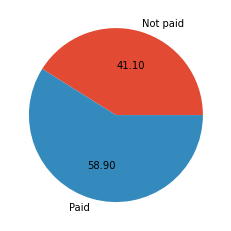

In [ ]:
# 현질유저는 몇 명?
no_cash = label.query('amount_spent == 0')['amount_spent'].count()
love_cash = label.query('amount_spent != 0')['amount_spent'].count()

print('현질 X :',no_cash,'\n현질 O :', love_cash)
plt.pie([no_cash, love_cash], labels=['Not paid','Paid'], autopct= '%.2f');

(40000, 3)


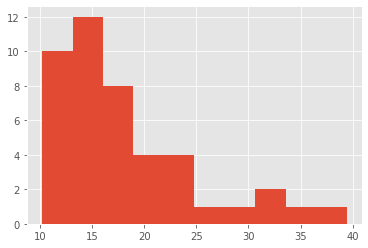

In [ ]:
print(label.shape)
plt.hist(label.query('amount_spent > 10')['amount_spent']);

### 2.1 결측치/중복값 확인하기
- join 할 때 외부 데이터에서 일정 결측값 존재하나, 해당 외부데이터에 값이 없는 경우는 그냥 이력이 없는 것으로 추후 결측치 처리시 0 으로 대채한다.
- key 값을 제외한 모든 값이 numeric data
- 중복값은 없다.

In [ ]:
# 데이터 타입 및 결측값 확인
df_merge.info()

df_merge[df_merge.duplicated( keep = False)] # 중복값 없음

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1111906 entries, 0 to 1111905
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   day                    1111906 non-null  int64  
 1   acc_id                 1111906 non-null  int64  
 2   playtime               1111906 non-null  float64
 3   npc_kill               1111906 non-null  float64
 4   solo_exp               1111906 non-null  float64
 5   party_exp              1111906 non-null  float64
 6   quest_exp              1111906 non-null  float64
 7   rich_monster           1111906 non-null  int64  
 8   death                  1111906 non-null  float64
 9   revive                 1111906 non-null  float64
 10  exp_recovery           1111906 non-null  float64
 11  fishing                1111906 non-null  float64
 12  private_shop           1111906 non-null  float64
 13  game_money_change      1111906 non-null  float64
 14  enchant_count     

,day,acc_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,...,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent,pledge_activated_rate,amount_spent,freq_selling,freq_buying


### 2.2 Numeric data 살펴보기
#### 2.2.1 통계치

In [ ]:
# 수치형 변수 대푯값 살펴보기
df_merge.describe().T

,count,mean,std,min,25%,50%,75%,max
day,1111906.000,14.841,8.100,1.000,8.000,15.000,22.000,28.000
acc_id,1111906.000,65321.873,37493.228,2.000,32944.000,65373.000,97635.000,130473.000
playtime,1111906.000,1.776,1.233,0.000,0.564,1.606,3.214,3.682
npc_kill,1111906.000,0.860,1.430,0.000,0.000,0.217,1.028,17.866
solo_exp,1111906.000,0.423,1.743,0.000,0.000,0.009,0.065,69.326
party_exp,1111906.000,0.216,1.472,0.000,0.000,0.000,0.002,106.446
quest_exp,1111906.000,0.191,1.558,0.000,0.000,0.000,0.003,108.844
rich_monster,1111906.000,0.225,0.465,0.000,0.000,0.000,0.000,8.000
death,1111906.000,0.134,0.963,0.000,0.000,0.000,0.000,221.541
revive,1111906.000,0.122,0.961,0.000,0.000,0.000,0.000,222.851


In [ ]:
# 분포 리포트
# profile = ProfileReport(df_merge, title = 'profiling', minimal= True)
# profile.to_file("report.html")

### 3. 상관관계

<AxesSubplot:>

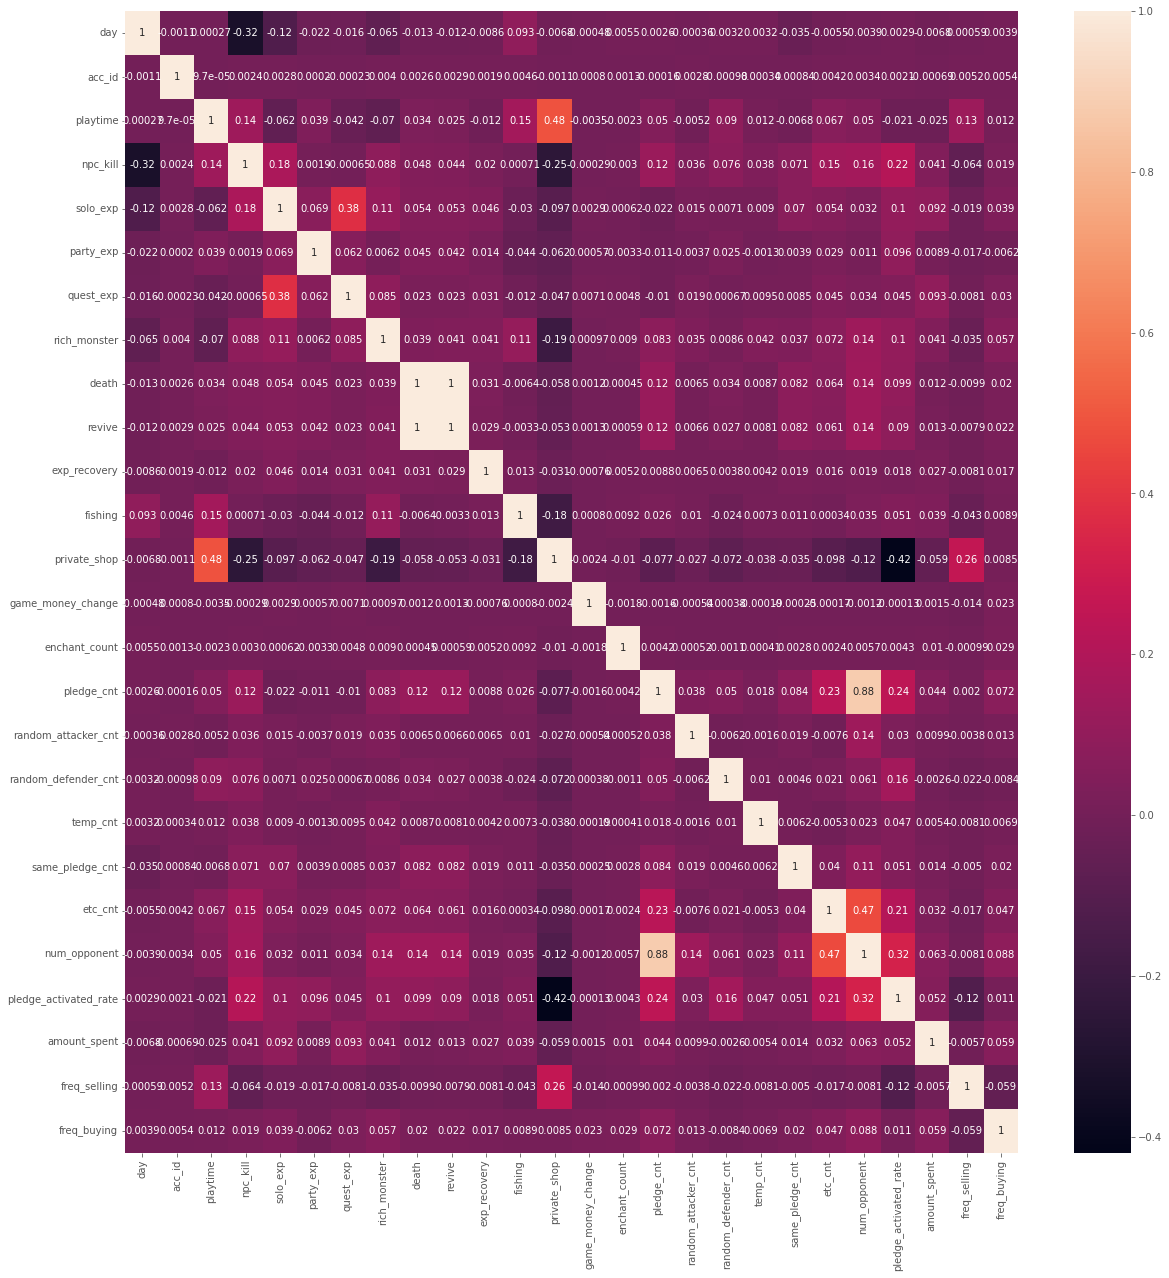

In [ ]:
plt.figure(figsize = (20,20))
corr = df_merge.corr()
sns.heatmap(corr, annot = True); # revive 와 death 는 너무 높은 상관관계. revive drop 하자

상관관계를 살펴보면...
- 플레이타임은 개인상점 운영시간과 강한 상관관계를 갖는다. (그도 그럴 것이 둘다 '시간' 개념이기에...거래 빈도 데이터를 만들었으니 이 컬럼은 드롭한다.)
- 재미있는 점은 개인상점 운영시간과 소속 혈맹의 활성화 정도는 음의 상관관계를 갖는다. 거래용 계정은 혈맹 가입이 없거나 전투를 거의 안하는 혈맹에 가입하는 것일까?
- 혈맹간 전투 참여횟수와 전투 상대 캐릭터 수는 강한 양의 상관관계. 당연하다. 전투에 많이 참여할 수록 전투 상대 캐릭터는 많을 수 밖에. 상관관계가 너무 높으므로 전투 상대 캐릭터 수는 드롭한다.
- 이정도 정리하면 상관관계 문제는 발생안할듯.

# 3. Data wrangling & Feature engineering
### 3.1 필요없는 컬럼 드랍, 로그변환, 클러스터 라벨링 (시퀸스)

In [56]:
train = df_merge.copy()

# 필요없는 컬럼 드랍
drop_col = ['revive','private_shop','num_opponent']
train.drop(drop_col, axis = 1, inplace = True)

In [62]:
train.skew()

day                      -0.042
acc_id                    0.001
playtime                  0.069
npc_kill                  2.574
solo_exp                  9.882
party_exp                16.291
quest_exp                12.077
rich_monster              2.272
death                    56.928
exp_recovery             15.093
fishing                   3.320
game_money_change        -5.448
enchant_count            59.014
pledge_cnt               10.559
random_attacker_cnt      33.932
random_defender_cnt      28.144
temp_cnt                105.023
same_pledge_cnt          23.739
etc_cnt                  17.440
pledge_activated_rate     0.658
amount_spent             10.355
freq_selling             17.492
freq_buying              15.377
cluster                   0.246
dtype: float64

### 3.2 클러스터링 (day 기준)
| 고객 분류에 사용할 라벨을 생성하기 위하여 k-means clustering을 사용한다.
scaler -> 

In [68]:
# clustering
n_clusters = [2,3,4,5,6]

# for k in n_clusters:
#     pipe_day = make_pipeline(
#         StandardScaler(),
#         SimpleImputer(strategy='constant', fill_value = 0),
#         KMeans(n_clusters = n_clusters, random_state= random_states)
#     )

#     cluster = pipe_day.fit(train)
#     cluster_labels = cluster['kmeans'].predict(train)
#     S = silhouette_score(train, cluster_labels)
#     print(f'n_clusters = {k}, silhouette score {S}')


pipe_day = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='constant', fill_value = 0),
    KMeans(n_clusters = 2, random_state= random_states)
)

cluster = pipe_day.fit(train)
cluster_labels = cluster['kmeans'].predict(train)
S = silhouette_score(train, cluster_labels)
print(f'n_clusters = {2}, silhouette score {S}')

c:\Users\jamsu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# 실루엣 계수를 활용하기


# 번외. 일단 만들어보는 클러스터링 모델 (임시)
**RFM에 기반**   
R : 28 - day에서 가장 마지막 값 (접속 후 경과 시간)   
F : 접속 빈도 (day 빈도를 count)   
M : 매몰 비용에 따라 (돈/시간/관계)   
- playtime 총 시간 
- payment 총 금액
- 관계 매몰비용은 어떻게 정의할 것인가?   
  - 혈맹간 전투에 참여한 횟수? 
  - 동일 혈맹원 간의 전투 횟수?
  -> 이를 정의하기 위해서는 리니지 내 혈맹간 전투가 얼마나 자주 일어나는지 확인할 필요가 있다.
 

In [ ]:
train_tmp = activity.groupby('char_id').mean()

In [ ]:
features = ['day','playtime','npc_kill','solo_exp','party_exp','quest_exp','rich_monster','death','fishing','private_shop','enchant_count']
train_tmp.describe()

,day,acc_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
count,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000,150960.000
mean,14.881,65472.859,0.459,0.206,0.186,0.075,0.207,0.059,0.043,0.039,0.031,0.080,0.112,-0.001,0.010
std,6.079,37446.483,0.844,0.503,0.686,0.651,1.070,0.148,0.650,0.653,0.258,0.296,0.524,0.403,0.350
min,1.000,2.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-42.614,0.000
25%,12.000,33129.000,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000
50%,14.500,65749.000,0.033,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,18.000,97717.000,0.476,0.077,0.013,0.000,0.004,0.000,0.007,0.000,0.000,0.000,0.000,0.000,0.000
max,28.000,130473.000,3.355,11.963,20.376,35.710,20.091,1.000,146.792,147.660,15.949,3.371,3.273,32.656,62.949


In [ ]:
train_tmp['cluster'] = cluster['kmeans'].labels_

c:\Users\jamsu\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


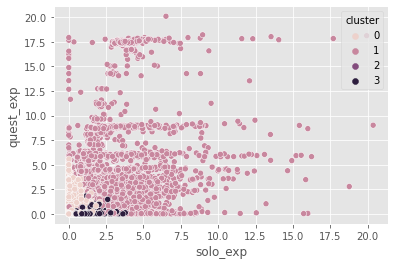

In [ ]:
sns.scatterplot(x = 'solo_exp', y = 'quest_exp', data = train_tmp, hue = 'cluster');

In [ ]:
print(train_tmp['cluster'].value_counts())
train_tmp.groupby('cluster').mean()

0    117817
3     23103
1      5090
2      4950
Name: cluster, dtype: int64


,day,acc_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
cluster,,,,,,,,,,,,,,,
0,14.730,65501.119,0.149,0.039,0.060,0.032,0.087,0.015,0.020,0.018,0.011,0.015,0.023,-0.003,0.003
1,19.007,65246.886,0.713,0.455,2.805,1.195,3.885,0.185,0.285,0.278,0.166,0.057,0.004,0.046,0.007
2,14.763,64466.351,3.060,0.003,0.007,0.001,0.011,0.002,0.001,0.001,0.000,0.003,2.847,0.010,0.000
3,14.771,65594.183,1.425,1.045,0.291,0.067,0.048,0.269,0.114,0.101,0.109,0.434,0.005,-0.000,0.048


클러스터링 결과를 분석하면...   
- 클러스터 1은 플레이타임, 활동 내역, 게임머니 모든 것이 적은 것으로 보아 접속 빈도가 낮은 라이트 유저으로 추정된다.
- 클러스터 2는 플레이도 자주 하고 여러 사냥, 레이드, PK 등 다양한 활동을 적극적으로 하는 유저층이다. 사냥활동, 낚시와 같은 직접적인 인게임 내 활동 내역이 다른 유저보다 크다. 
- 클러스터 3은 플레이타임은 길지만 게임 내 활동은 저조하다. 사냥활동도 거의 하지 않는다. 다만 개인상점이용 빈도가 압도적으로 높고, 게임 머니 증가량이 평균적으로 높은 것을 보아, 그냥 접속해두고 아이템 거래만 하는 유저인 것으로 추정된다.